<html>
<body>
<h1> <b>Large-Scale Counterfactual Training for Object Classification </b> </h1>
<p> Author: Anshu Garg</p>
<p> Email: a_garg19@cs.uni-kl.de </p>
<p> Matrikel Nummer: 414686 </p>

</body>

</html>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

Using GPU

In [ ]:
if torch.cuda.is_available():
  device=torch.device('cuda')
  print('Using GPU')
else:
  device=torch.device('cpu')

Initializing the BatchSize

In [ ]:
bs=100

Data Preperation

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0, 0, 0), (1, 1, 1))])

trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=4)
classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


Creating customized Dataset

In [ ]:
class Colored_set(torch.utils.data.Dataset):
  def __init__(self,array,targets,transform):
    self.array=array
    self.labels=targets
    self.transform=transform

  def __len__(self):
    return self.array.shape[0]
  def __getitem__(self,index):
    img,target=self.array[index],self.labels[index]
    img=self.transform(img)
    return img,target

Conversion of Images to only Red, Blue, Green channels each.

In [ ]:
def channel_copy(dataset,color='red'):
    """Isolates a specific channel in the given Image.
    parameters:
    dataset: pytorch dataset
    color: color channel that should be lone present in the output image
    
    Returs a tensor with single color across all the channels.
    """
    if color=='red' or color=='red_test':
        index=0
    elif color=='green' or color=='green_test':
        index=1
    elif color=='blue' or color=='blue_test':
        index=2
    else:
        print('Invalid Entry. Switching to default red')
        index=0;color=red

    array=np.asarray(dataset.data)
    inlist=[]; outlist=[]   # outlist=torch.empty((array.shape[0],array.shape[3],array.shape[2],array.shape[1]))
    for i in range(0,array.shape[0]):
        inlist=[]
        for j in range(0,array.shape[1]):
            inlist.append(np.reshape(np.repeat(array[i][j][:,index],array.shape[3]),(array.shape[2],array.shape[3])))
        outlist.append(inlist)
    return Colored_set(np.array(outlist),dataset.targets,transform=transform)


Createing Dataloaders for customized datasets (red, green, blue)

In [ ]:
data_sets=[];loaders=[trainloader,testloader];color_set=['red','red_test','green','green_test','blue','blue_test']
dst=[trainset, testset]
for i in range(3):
  color_c=0
  for j in range(2):
      ds=channel_copy(dst[j],color=color_set[color_c])
      color_c+=1
      if j==1:
              loaders.append(torch.utils.data.DataLoader(ds, batch_size=bs,shuffle=False, num_workers=4))
      else:
        loaders.append(torch.utils.data.DataLoader(ds, batch_size=bs,shuffle=True, num_workers=4))



In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

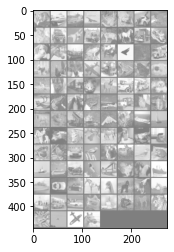

GroundTruth:   cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog  deer   dog truck  bird  deer   car truck   dog  deer  frog   dog  frog plane truck   cat truck horse  frog truck  ship plane   cat  ship  ship horse horse  deer  frog horse   cat  frog   cat  frog  bird   car  bird   cat horse  bird  frog  ship  ship plane  bird truck   cat   cat  ship  ship   car   car horse  bird   dog  bird horse  ship truck plane   cat  ship  frog  deer  frog  frog plane plane horse


In [ ]:
dataiter=iter(loaders[3])
images,labels=dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth:',' '.join('%5s'%classes[labels[j]] for j in range(100)))

In [ ]:
trainloaders=[]; testloaders=[]; accuracy=[]
for i in loaders:
  if loaders.index(i)%2==0:
    trainloaders.append(i)
  else:
    testloaders.append(i)

Training and Checking the Accuracy of the Test Set.

In [ ]:
totalaccuracy=[];total_class_accuracy=[]
for train in range(len(trainloaders)):
  resmodel=torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)
  resmodel.to(device)
  loss=nn.CrossEntropyLoss()
  sgd = optim.SGD(resmodel.parameters(), lr=1e-1, momentum=0.9);
  for epoch in range(10):
      append_loss=0
      for i, data in enumerate (trainloaders[train], 0):
          inputs_1, labels_1=data; inputs,labels=inputs_1.to(device),labels_1.to(device)
          sgd.zero_grad()
          outputs=resmodel(inputs)
          cost=loss(outputs,labels)
          cost.backward()
          sgd.step()
          path='../data/{}.pth'.format(train)
          append_loss+=cost.item()

          if i%500==499:
              print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, append_loss/500))
              append_loss=0
  print('Finished Training')
  path='../data/{}'.format(train)
  torch.save(resmodel.state_dict(),path) # for redundancy
  correct = 0;total = 0; class_correct=list(0. for i in range(10)); class_total = list(0. for i in range(10))
  with torch.no_grad():
      for data in testloaders[train]:
                images_1, labels_1 = data; images,labels=images_1.to(device), labels_1.to(device)
                outputs = resmodel(images)
                _, predicted = torch.max(outputs.data, 1)
                _, predicted_class=torch.max(outputs,1)
                c=(predicted_class==labels).squeeze()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                for i in range(4):
                  label=labels[i]
                  class_correct[label]+=c[i].item();class_total[label]+=1
  ca=[]
  for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
    ca.append(100 * class_correct[i] / class_total[i])
  total_class_accuracy.append(ca)
  totalaccuracy.append(100 * correct / total)
  print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


[1,   500] loss: 2.171
[2,   500] loss: 1.364
[3,   500] loss: 1.140
[4,   500] loss: 0.976
[5,   500] loss: 0.850
[6,   500] loss: 0.741
[7,   500] loss: 0.660
[8,   500] loss: 0.573
[9,   500] loss: 0.497
[10,   500] loss: 0.430
Finished Training
Accuracy of plane : 77 %
Accuracy of   car : 87 %
Accuracy of  bird : 57 %
Accuracy of   cat : 48 %
Accuracy of  deer : 59 %
Accuracy of   dog : 65 %
Accuracy of  frog : 84 %
Accuracy of horse : 84 %
Accuracy of  ship : 87 %
Accuracy of truck : 68 %
Accuracy of the network on the 10000 test images: 72 %


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


[1,   500] loss: 2.272
[2,   500] loss: 1.515
[3,   500] loss: 1.285
[4,   500] loss: 1.089
[5,   500] loss: 0.955
[6,   500] loss: 0.857
[7,   500] loss: 0.770
[8,   500] loss: 0.664
[9,   500] loss: 0.588
[10,   500] loss: 0.502
Finished Training
Accuracy of plane : 70 %
Accuracy of   car : 78 %
Accuracy of  bird : 57 %
Accuracy of   cat : 46 %
Accuracy of  deer : 59 %
Accuracy of   dog : 65 %
Accuracy of  frog : 75 %
Accuracy of horse : 84 %
Accuracy of  ship : 70 %
Accuracy of truck : 75 %
Accuracy of the network on the 10000 test images: 69 %


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


[1,   500] loss: 2.234
[2,   500] loss: 1.627
[3,   500] loss: 1.335
[4,   500] loss: 1.135
[5,   500] loss: 0.989
[6,   500] loss: 0.870
[7,   500] loss: 0.772
[8,   500] loss: 0.676
[9,   500] loss: 0.590
[10,   500] loss: 0.514
Finished Training
Accuracy of plane : 68 %
Accuracy of   car : 84 %
Accuracy of  bird : 65 %
Accuracy of   cat : 48 %
Accuracy of  deer : 61 %
Accuracy of   dog : 68 %
Accuracy of  frog : 73 %
Accuracy of horse : 84 %
Accuracy of  ship : 75 %
Accuracy of truck : 65 %
Accuracy of the network on the 10000 test images: 70 %


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


[1,   500] loss: 2.132
[2,   500] loss: 1.467
[3,   500] loss: 1.217
[4,   500] loss: 1.044
[5,   500] loss: 0.938
[6,   500] loss: 0.811
[7,   500] loss: 0.703
[8,   500] loss: 0.610
[9,   500] loss: 0.520
[10,   500] loss: 0.441
Finished Training
Accuracy of plane : 75 %
Accuracy of   car : 84 %
Accuracy of  bird : 55 %
Accuracy of   cat : 34 %
Accuracy of  deer : 61 %
Accuracy of   dog : 59 %
Accuracy of  frog : 75 %
Accuracy of horse : 81 %
Accuracy of  ship : 77 %
Accuracy of truck : 86 %
Accuracy of the network on the 10000 test images: 69 %


In [ ]:
for i in total_class_accuracy:
  print('accuracy per class')
  print (i)

accuracy per class
[77.27272727272727, 87.5, 57.89473684210526, 48.83720930232558, 59.183673469387756, 65.625, 84.90566037735849, 84.375, 87.5, 68.96551724137932]
accuracy per class
[70.45454545454545, 78.125, 57.89473684210526, 46.51162790697674, 59.183673469387756, 65.625, 75.47169811320755, 84.375, 70.83333333333333, 75.86206896551724]
accuracy per class
[68.18181818181819, 84.375, 65.78947368421052, 48.83720930232558, 61.224489795918366, 68.75, 73.58490566037736, 84.375, 75.0, 65.51724137931035]
accuracy per class
[75.0, 84.375, 55.26315789473684, 34.883720930232556, 61.224489795918366, 59.375, 75.47169811320755, 81.25, 77.08333333333333, 86.20689655172414]


In [ ]:
import pandas as pd 

In [ ]:
class_per=pd.DataFrame(total_class_accuracy)
channel_acc=pd.DataFrame(totalaccuracy)

In [ ]:
import plotly.graph_objects as go



In [ ]:
classes.append('Testset Accuracy');count=0
for i in total_class_accuracy:
  
  i.append(totalaccuracy[count])
  count+=1

['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse']

Tabulating the results.

In [ ]:
channels=['Original','Red_channel','Green_channel','Blue_Channel']

fig = go.Figure(data=[go.Table(header=dict(values=['Classes', 'Accuracy of '+str(channels[0]),'Accuracy of '+str(channels[1]),'Accuracy of '+str(channels[2]),'Accuracy of '+str(channels[3])]),cells=dict(values=[classes, total_class_accuracy[0],total_class_accuracy[1],total_class_accuracy[2],total_class_accuracy[3]]))  ])
fig.show()


In [ ]:
files.download('../data/classwiseaccuracy.csv')
files.download('../data/channelwiseaccuracy.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

In [ ]:
files.download('../data/0')
files.download('../data/1')
files.download('../data/2')
files.download('../data/3')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>